# Questions 

# Import, options

In [76]:
import numpy, seaborn, pandas
import scipy.stats as stats
import matplotlib, matplotlib.pyplot as plt

import statsmodels.api

from statsmodels.stats.multitest import multipletests
from scipy.stats import linregress
from scipy.stats import f_oneway

from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as sch

In [77]:
matplotlib.rcParams.update({'svg.fonttype' : 'none'})
#'font.size':20, 'xtick.labelsize':20, 'ytick.labelsize':20,'axes.grid' : True, 'grid.alpha': 0.5, 'grid.linestyle' : ':',                            'figure.figsize':(8, 5), 

In [78]:
file_directory = "/Users/kja11/OneDrive - Menntaský/PostDoc_Hypothermia/in_silico/Python/"

# Data Download

In [79]:
# Values are Protein abundance by TMT reporter ion intensity
# Stats are ANOVA
# Peptides number = 15487

In [80]:
#data DEseq HEK293 significant ones
df_annotated = pandas.read_csv(file_directory+'1) input/proteomics/Pilot_ProteomicsData.csv',
                               sep = ',')
print(df_annotated.shape, '\n', df_annotated.columns)
df_annotated.head(3)

(2405, 26) 
 Index(['Accession', 'Protein', 'Gene', 'Coverage [%]', '# Peptides',
       'Ctrl_BR1', 'Ctrl_BR2', 'Ctrl_BR3', '3h_BR1', '3h_BR2', '3h_BR3',
       '6h_BR1', '6h_BR2', '6h_BR3', '9h_BR1', '9h_BR2', '9h_BR3', '12h_BR1',
       '12h_BR2', '12h_BR3', '16h_BR1', '16h_BR2', '16h_BR3', 'F.stat',
       'p.value', 'Neglog10p'],
      dtype='object')


,Accession,Protein,Gene,Coverage [%],# Peptides,Ctrl_BR1,Ctrl_BR2,Ctrl_BR3,3h_BR1,3h_BR2,...,9h_BR3,12h_BR1,12h_BR2,12h_BR3,16h_BR1,16h_BR2,16h_BR3,F.stat,p.value,Neglog10p
0,Q9Y2L1,Exosome complex exonuclease RRP44,DIS3,6,4,92.2,96.5,92.9,96.6,87.0,...,103.2,102.0,103.0,105.8,102.4,117.6,115.5,11.787,0.000272,3.5657
1,Q6PKG0,La-related protein 1,LARP1,11,10,99.6,103.3,103.5,107.7,106.6,...,99.1,95.3,99.7,93.3,94.8,92.5,93.2,10.947,0.000386,3.4138
2,P60709,"Actin, cytoplasmic 1",ACTB,71,29,100.0,101.7,100.9,107.7,107.1,...,98.2,96.5,93.9,91.1,99.1,100.4,105.6,10.507,0.000467,3.3304


In [81]:
# See if we have duplicate in Gene ( = having isoforms)
df_annotated.duplicated(subset=["Gene"]).sum()

0

In [82]:
# Only select expression columns
df = df_annotated.set_index('Gene')
df = df.iloc[:,4:-3]
df.head(2)

,Ctrl_BR1,Ctrl_BR2,Ctrl_BR3,3h_BR1,3h_BR2,3h_BR3,6h_BR1,6h_BR2,6h_BR3,9h_BR1,9h_BR2,9h_BR3,12h_BR1,12h_BR2,12h_BR3,16h_BR1,16h_BR2,16h_BR3
Gene,,,,,,,,,,,,,,,,,,
DIS3,92.2,96.5,92.9,96.6,87.0,97.6,91.6,92.3,90.3,107.6,105.8,103.2,102.0,103.0,105.8,102.4,117.6,115.5
LARP1,99.6,103.3,103.5,107.7,106.6,103.5,103.5,106.4,101.5,94.0,102.6,99.1,95.3,99.7,93.3,94.8,92.5,93.2


# Data transformation

## Linregress to select increase or decrease overtime

### NoCtl in the slope

In [83]:
# Regression is about time. So, exclude 37°C to keep 32°C and the time points 
df_linregress = df.iloc[:,3:]

##Change df name as numeric to run linregress - 3,3,3 because of triplicate of 3 hours.
df_linregress.columns = [ 3, 3, 3, 6, 6, 6, 9, 9, 9, 12, 12, 12, 16, 16 , 16]
print(df_linregress.columns)


## LinRegress Slope (output: slope, intercept, rvalue, pvalue)
df_linregress_noCTL = df_linregress.assign(slope = (df_linregress.apply(lambda row: linregress(row.index, row.values).slope, axis=1)),
                                     intercept = (df_linregress.apply(lambda row: linregress(row.index, row.values).intercept, axis=1)),
                                     rvalue = (df_linregress.apply(lambda row: linregress(row.index, row.values).rvalue, axis=1)),
                                     pvalue = (df_linregress.apply(lambda row: linregress(row.index, row.values).pvalue, axis=1)))

# Only select linregress values
df_linregress_noCTL.head(5)

Index([3, 3, 3, 6, 6, 6, 9, 9, 9, 12, 12, 12, 16, 16, 16], dtype='int64')


,3,3,3,6,6,6,9,9,9,12,12,12,16,16,16,slope,intercept,rvalue,pvalue
Gene,,,,,,,,,,,,,,,,,,,
DIS3,96.6,87.0,97.6,91.6,92.3,90.3,107.6,105.8,103.2,102.0,103.0,105.8,102.4,117.6,115.5,1.515694,87.275616,0.805491,0.000290
LARP1,107.7,106.6,103.5,103.5,106.4,101.5,94.0,102.6,99.1,95.3,99.7,93.3,94.8,92.5,93.2,-1.009533,108.867704,-0.877613,0.000017
ACTB,107.7,107.1,103.4,102.3,102.3,103.0,94.4,92.6,98.2,96.5,93.9,91.1,99.1,100.4,105.6,-0.490661,104.354086,-0.435866,0.104359
PSMA2,111.4,104.4,106.1,104.9,106.0,102.1,96.3,94.2,93.9,93.9,98.1,95.4,91.1,104.2,94.6,-0.902140,108.073022,-0.692949,0.004183
PRRC1,119.6,102.7,107.6,108.2,104.0,105.6,86.3,90.7,91.0,91.1,92.3,90.8,97.0,109.5,96.7,-0.928729,108.084306,-0.461475,0.083357


In [84]:
# adjusted p_value 
sign_answer, adj_pvalue, c , d  = multipletests(df_linregress_noCTL['pvalue'], alpha = 0.05, method='fdr_bh')
df_linregress_noCTL['adj_pvalue'] = adj_pvalue

# Select the proteins with significant Linregress nonAdj pavlue
signif_nonAjd_linregress_proteins1 = list(df_linregress_noCTL[df_linregress_noCTL['pvalue'] < 0.05].index)
print(f'on the {len(df_linregress_noCTL)} proteins, {len(signif_nonAjd_linregress_proteins1)} have significant linregress (non adjusted)')

# Select the proteins with significant Linregress Adjusted pvalue
adjPvalue_signif_linregress_proteins1 = list(df_linregress_noCTL[df_linregress_noCTL['adj_pvalue'] < 0.05].index)
print(f'\non the {len(df_linregress_noCTL)} proteins, {len(adjPvalue_signif_linregress_proteins1)} have adjusted significant linregress:')

print(adjPvalue_signif_linregress_proteins1)

on the 2405 proteins, 532 have significant linregress (non adjusted)

on the 2405 proteins, 22 have adjusted significant linregress:
['DIS3', 'LARP1', 'NUP93', 'NDUFB8', 'CTNND1', 'RPL21', 'KARS1', 'SRSF5', 'ATG3', 'AGPS', 'CIRBP', 'RPL19', 'RPS18', 'ERP44', 'RPS20', 'THRAP3', 'FUS', 'RPL13', 'RBM8A', 'MDC1', 'PRPF3', 'HNRNPL']


In [85]:
# Select absolute Rvalue from that:
high_Rval_prot_noCTL = df_linregress_noCTL[(df_linregress_noCTL['rvalue']< -0.6) 
                                     |(df_linregress_noCTL['rvalue'] > 0.6) ].index
len(high_Rval_prot_noCTL)

302

In [86]:
# Select the targets and see if we selected them:
targets = 'CIRBP', 'RBM3', 'SMYD5'
df_linregress_noCTL.loc[targets,:].iloc[:,-5:]

,slope,intercept,rvalue,pvalue,adj_pvalue
Gene,,,,,
CIRBP,2.534112,78.746174,0.815935,0.000208,0.033331
RBM3,3.328080,72.288327,0.736582,0.001736,0.080206
SMYD5,-2.081712,118.285084,-0.727675,0.002105,0.080206


In [89]:
# Save the list of significant linregress proteins for Overlapping
numpy.savetxt(file_directory+"3) output/Proteomics/high_Rvalue_linregress_proteins.txt", 
              high_Rval_prot_noCTL, delimiter="\t", fmt="% s")


df_linregress_noCTL.iloc[:,-5:].to_csv(file_directory+"3) output/Proteomics/df_linregress_noCTL.csv"
                           , sep=',')

## Select proteins from coefficient of variation

### general Variation (all the conditions)

In [22]:
# median instead of the separate triplicate
## Have median of the triplicate
df2 = df.copy()
df2.columns = df2.columns.str.split('_').str[0]

df2 = df2.assign(_ctl= (df2[['Ctrl']].median(axis=1)),
                 _3h= (df2[['3h']].median(axis=1)),
                 _6h= (df2[['6h']].median(axis=1)),
                 _9h= (df2[['9h']].median(axis=1)),
                 _12h= (df2[['12h']].median(axis=1)),
                 _16h= (df2[['16h']].median(axis=1)) )

df2 = df2.iloc[:,-6:]
print(df2.head())

        _ctl    _3h    _6h    _9h   _12h   _16h
Gene                                           
DIS3    92.9   96.6   91.6  105.8  103.0  115.5
LARP1  103.3  106.6  103.5   99.1   95.3   93.2
ACTB   100.9  107.1  102.3   94.4   93.9  100.4
PSMA2  101.3  106.1  104.9   94.2   95.4   94.6
PRRC1  103.6  107.6  105.6   90.7   91.1   97.0


C:\Users\kja11\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


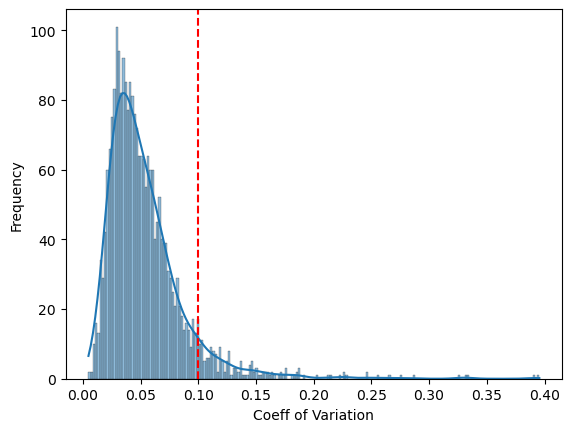

In [60]:
# coefficient of variation (CV) of gene expression across time points
cv_expression = df2.std(axis=1) / df2.mean(axis=1)

seaborn.histplot(cv_expression, bins=200, kde=True)
# plt.title('Histogram of the Coeff of Variation')
plt.xlabel('Coeff of Variation')
plt.ylabel('Frequency')

threshold = 0.1
plt.axvline(threshold,color="red",linestyle="--")
plt.show()

In [61]:
print(len(cv_expression[cv_expression > threshold]), '\n')

HighCV_prot = cv_expression[cv_expression > threshold].index

targets = 'CIRBP', 'RBM3', 'SMYD5'
for target in targets:
    print(target, cv_expression[target])

174 

CIRBP 0.13410257811454962
RBM3 0.16388714556587683
SMYD5 0.12194110824260447


In [62]:
# Save the list of significant linregress proteins for Overlapping
numpy.savetxt(file_directory+"3) output/Proteomics/high_CoeffVar_proteins.txt", 
              HighCV_prot, delimiter="\t", fmt="% s")

In [63]:
set1 = set(high_Rval_prot_noCTL)
set2 = set(HighCV_prot)

common_elements = set(set1).intersection(set2)
common_elements = list(common_elements)
len(common_elements)

45

### Variation between CTRL and 3h to select early response proteins

C:\Users\kja11\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


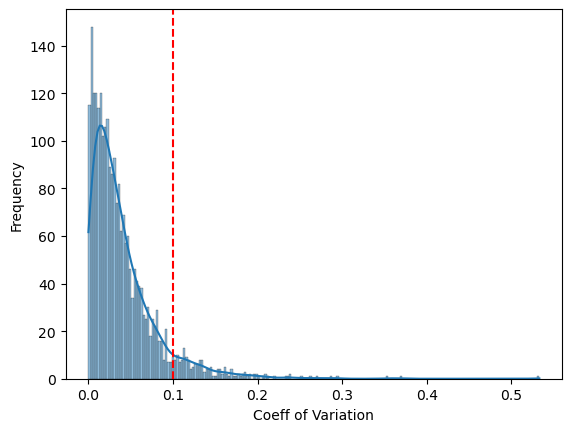

In [64]:
# coefficient of variation (CV) of gene expression between 3h and CTL
cv_expression = df2.iloc[:,:2].std(axis=1) / df2.iloc[:,:2].mean(axis=1)

seaborn.histplot(cv_expression, bins=200, kde=True)
# plt.title('Histogram of the Coeff of Variation')
plt.xlabel('Coeff of Variation')
plt.ylabel('Frequency')

threshold = 0.1
plt.axvline(threshold,color="red",linestyle="--")
plt.show()

In [72]:
print(len(cv_expression[cv_expression > threshold]), '\n')

early_res_CV_prot = cv_expression[cv_expression > threshold].index

targets = 'CIRBP', 'RBM3', 'SMYD5'
for target in targets:
    
    if target in df[df.index.isin(early_res_CV_prot)].index:
        print(target, cv_expression[target], target,'yes')
    else:
        print(target, cv_expression[target], target,'non selected')

print('\nSMYD5 is here, not the two other. This is normal they changed at 9H')

179 

CIRBP 0.032052380352292326 CIRBP non selected
RBM3 0.0008275093986969074 RBM3 non selected
SMYD5 0.1139049837567471 SMYD5 yes

SMYD5 is here, not the two other. This is normal they changed at 9H


In [73]:
# Save the list of significant linregress proteins for Overlapping
numpy.savetxt(file_directory+"3) output/Proteomics/Early_res_CoeffVar_proteins.txt", 
              early_res_CV_prot, delimiter="\t", fmt="% s")